In [1]:
%%capture
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from time import time
import numpy as np

In [2]:
def densenet(img_shape, n_classes, f=32):
  repetitions = 6, 12, 24, 16
  
  def bn_rl_conv(x, f, k=1, s=1, p='same'):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(f, k, strides=s, padding=p)(x)
    return x
  
  
  def dense_block(tensor, r):
    for _ in range(r):
      x = bn_rl_conv(tensor, 4*f)
      x = bn_rl_conv(x, f, 3)
      tensor = Concatenate()([tensor, x])
    return tensor
  
  
  def transition_block(x):
    x = bn_rl_conv(x, K.int_shape(x)[-1] // 2)
    x = AvgPool2D(2, strides=2, padding='same')(x)
    return x
  
  
  input = Input(img_shape)
  
  x = Conv2D(64, 7, strides=2, padding='same')(input)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  for r in repetitions:
    d = dense_block(x, r)
    x = transition_block(d)
  
  x = GlobalAvgPool2D()(d)
  
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  return model

In [10]:
input_shape = 48, 48, 3
n_classes = 7

K.clear_session()
model = densenet(input_shape, n_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 24, 24, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 12, 12, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 12, 12, 64)   256         max_pooling2d[0][0]              
______________________________________________________________________________________________

In [16]:
model.compile(optimizer="adam", 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

In [17]:
data_dir = 'DATA/FER+CK/train/'
val_dir = 'DATA/FER+CK/val/'

In [18]:
epochs = 300
batch_size = 64

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        shear_range=.2,
                        horizontal_flip=True,
                        validation_split=0.2)

train_generator = datagen_train.flow_from_directory(data_dir,
                                                    target_size=(48,48),
                                                    batch_size= batch_size,
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    shuffle=True)

datagen_val = ImageDataGenerator(featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        shear_range=.2,
                        horizontal_flip=True)

val_generator = datagen_val.flow_from_directory(val_dir,
                                                target_size=(48,48),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                color_mode='rgb',
                                                shuffle=False) 


Found 29440 images belonging to 7 classes.
Found 6723 images belonging to 7 classes.


In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

my_callbacks = [
                EarlyStopping(monitor='val_accuracy', min_delta=1e-5, patience=20, mode='auto', verbose=1),
                ModelCheckpoint(filepath='fer_model.h5', monitor='accuracy', save_best_only=True, save_weights_only=False, mode='auto', verbose=1)
]

In [21]:
history = model.fit(train_generator,
                    epochs=epochs, steps_per_epoch=len(train_generator), # How many mini_batchs we have inside each epoch.
                    validation_data=val_generator,
                    callbacks=my_callbacks,
                    verbose=1)

Epoch 1/300
460/460 [==============================] - 61s 104ms/step - loss: 1.9030 - accuracy: 0.2760 - val_loss: 5.0702 - val_accuracy: 0.1493

Epoch 00001: accuracy improved from -inf to 0.27602, saving model to fer_model.h5
Epoch 2/300
460/460 [==============================] - 46s 100ms/step - loss: 1.6005 - accuracy: 0.3791 - val_loss: 4.3493 - val_accuracy: 0.2795

Epoch 00002: accuracy improved from 0.27602 to 0.37914, saving model to fer_model.h5
Epoch 3/300
460/460 [==============================] - 46s 100ms/step - loss: 1.4518 - accuracy: 0.4416 - val_loss: 1.5429 - val_accuracy: 0.3992

Epoch 00003: accuracy improved from 0.37914 to 0.44164, saving model to fer_model.h5
Epoch 4/300
460/460 [==============================] - 46s 100ms/step - loss: 1.3626 - accuracy: 0.4771 - val_loss: 1.8674 - val_accuracy: 0.3060

Epoch 00004: accuracy improved from 0.44164 to 0.47711, saving model to fer_model.h5
Epoch 5/300
460/460 [==============================] - 46s 99ms/step - loss

460/460 [==============================] - 46s 100ms/step - loss: 0.2760 - accuracy: 0.8999 - val_loss: 0.8392 - val_accuracy: 0.7730

Epoch 00073: accuracy improved from 0.89742 to 0.89993, saving model to fer_model.h5
Epoch 74/300
460/460 [==============================] - 46s 100ms/step - loss: 0.2591 - accuracy: 0.9037 - val_loss: 2.1242 - val_accuracy: 0.7498

Epoch 00074: accuracy improved from 0.89993 to 0.90374, saving model to fer_model.h5
Epoch 75/300
460/460 [==============================] - 46s 101ms/step - loss: 0.2722 - accuracy: 0.9022 - val_loss: 0.9419 - val_accuracy: 0.7515

Epoch 00075: accuracy did not improve from 0.90374
Epoch 76/300
460/460 [==============================] - 46s 100ms/step - loss: 0.2600 - accuracy: 0.9066 - val_loss: 2.1340 - val_accuracy: 0.7442

Epoch 00076: accuracy improved from 0.90374 to 0.90656, saving model to fer_model.h5
Epoch 77/300
460/460 [==============================] - 46s 100ms/step - loss: 0.2382 - accuracy: 0.9142 - val_loss

460/460 [==============================] - 45s 99ms/step - loss: 0.1179 - accuracy: 0.9579 - val_loss: 1.0628 - val_accuracy: 0.7645

Epoch 00150: accuracy did not improve from 0.96145
Epoch 151/300
460/460 [==============================] - 46s 99ms/step - loss: 0.1073 - accuracy: 0.9620 - val_loss: 0.9185 - val_accuracy: 0.8278

Epoch 00151: accuracy improved from 0.96145 to 0.96196, saving model to fer_model.h5
Epoch 152/300
460/460 [==============================] - 46s 99ms/step - loss: 0.1089 - accuracy: 0.9607 - val_loss: 1.0022 - val_accuracy: 0.8096

Epoch 00152: accuracy did not improve from 0.96196
Epoch 153/300
460/460 [==============================] - 46s 100ms/step - loss: 0.1095 - accuracy: 0.9605 - val_loss: 1.0032 - val_accuracy: 0.7993

Epoch 00153: accuracy did not improve from 0.96196
Epoch 154/300
460/460 [==============================] - 46s 100ms/step - loss: 0.1045 - accuracy: 0.9621 - val_loss: 1.0754 - val_accuracy: 0.8057

Epoch 00154: accuracy improved fro

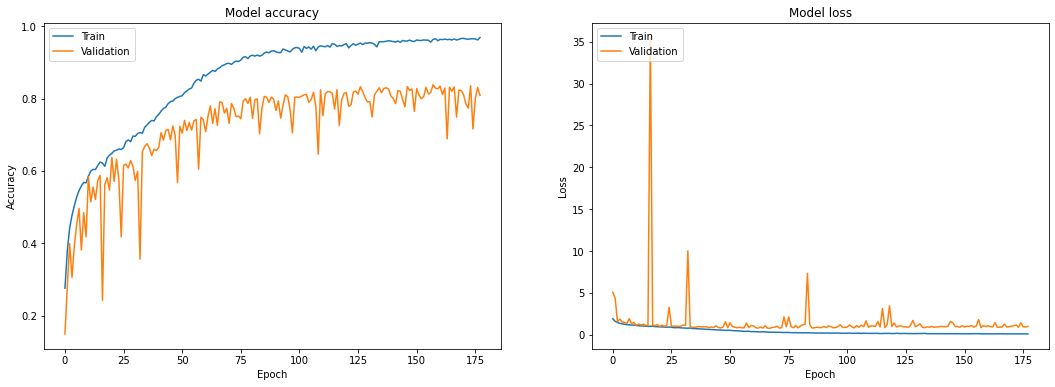

In [22]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2, figsize=(18, 6))

# Plot training & validation accuracy values

axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [23]:
from sklearn.metrics import accuracy_score

predictions = model.predict(val_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = val_generator.classes
class_names = val_generator.class_indices.keys()

print("Model Accuracy on test set: {:.4f}".format(accuracy_score(y_test, y_pred)))

Model Accuracy on test set: 0.8086


In [24]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.81      0.80       990
           1       0.91      0.78      0.84       162
           2       0.79      0.80      0.79      1025
           3       0.89      0.96      0.93      1796
           4       0.84      0.76      0.79      1734
           5       0.79      0.77      0.78       414
           6       0.52      0.54      0.53       602

    accuracy                           0.81      6723
   macro avg       0.79      0.78      0.78      6723
weighted avg       0.81      0.81      0.81      6723



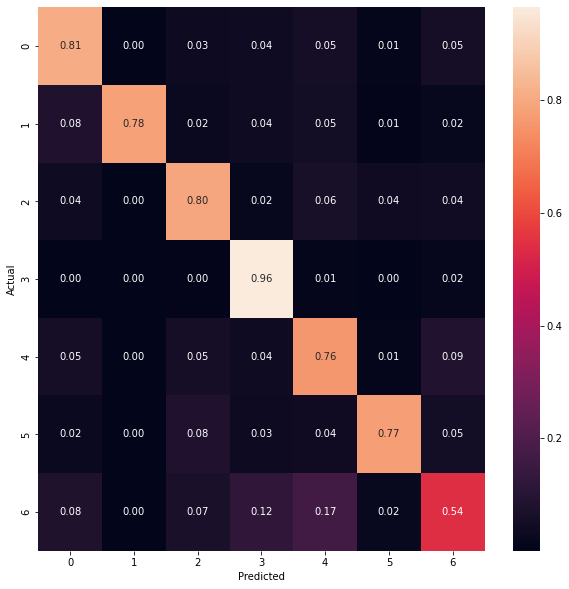

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [26]:
model_json = model.to_json()
with open("ferck_densenet.json", "w") as json_file:
    json_file.write(model_json)